# MASTER - Notebook 4
### Matteo Grazioso 884055

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import json
import os
import folium
import warnings
warnings.filterwarnings('ignore')

import myfunctions as mf # Custom functions

In [33]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

---------


In [34]:
def restrict_dataset_to_period(df, start_date, end_date):
    '''
    Restrict the dataset to only the specified period given by the user
        :param df: the dataset to be restricted
        :param start_date: the start date of the period
        :param end_date: the end date of the period
        :return: the restricted dataset        
    ''' 

    # Filter the dataset to only the specified period
    df = df[(df['DATA'] >= start_date) & (df['DATA'] <= end_date)]
    
    return df

In [35]:
# This notebbok open the dataset esportazioneCompleta in which is already applied the temporal data cleaning
# The notebook allows you to restrict the dataset to a specific time period (before Carnival, during Carnival, after Carnival) and export the dataset in a txt file 

In [36]:
path = 'data/processed/dataset_cleaned_tempesportazioneCompleta.txt'
df = pd.read_csv(path, header=0, sep='\t')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('_')[-1].split('.')[0]

subfolder = file_name
print(file_name)

# Display the first 5 rows of the dataframe
print(df.head())

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

tempesportazioneCompleta
         DATA       ORA     DATA_VALIDAZIONE            SERIALE  FERMATA  \
0  2023-01-13  00:00:00  2023-01-13 00:00:00  40834866809772548      162   
1  2023-01-13  00:00:00  2023-01-13 00:00:00        -3604990320     5049   
2  2023-01-13  00:00:00  2023-01-13 00:00:00        -2824230951     5043   
3  2023-01-13  00:00:00  2023-01-13 00:00:00  40552750134805252     5013   
4  2023-01-13  00:01:00  2023-01-13 00:01:00        -3604964420     6084   

    DESCRIZIONE  TITOLO TICKET_CODE            DESCRIZIONE_TITOLO  
0  Stazione MES   12101           7   BIGL.AUT.75'MESTRE/LIDO-TSC  
1   Zattere "B"   23301      5-STUD      MENS.STUDENTE RETE UNICA  
2  S. Toma' "B"   23303      6-STUD  ABB STUD. RETEUNICA 12 MESI   
3  S. Marco-San   11101           7        75'-TPL 8,64-COMVE0,86  
4  VENEZIA CORS   11209           7           BIGL RETE UNICA 75'  


In [37]:
# Ask in input if the user wants to restrict the analysis to a specific period (Before carnival, during carnival, after carnival)
# If the user wants to restrict the analysis, the user has to specify the number of the period (1, 2, 3)
# If the user doesn't want to restrict the analysis, the user has to specify the number 0

while True:
    input_period = input("Do you want to restrict the analysis to a specific period? (Yes/No) ")
    if input_period == "Yes" or input_period == "yes" or input_period == "Y" or input_period == "y":
        while True:
            input_period_number = input("Which period do you want to restrict the analysis to? (1: Before Carnival, 2: During Carnival, 3: After Carnival) ")
            if not input_period_number.isdigit():
                print("Enter a valid number.")
                continue
            input_period_number = int(input_period_number)
            if input_period_number == 1:
                period = "before_carnival"
                break
            elif input_period_number == 2:
                period = "during_carnival"
                break
            elif input_period_number == 3:
                period = "after_carnival"
                break
            else:
                print("You have to specify a number between 1 and 3!")
                continue
        break
    elif input_period == "No" or input_period == "no" or input_period == "N" or input_period == "n":
        period = "All the period"
        input_period_number = 0
        break
    else:
        print("You have to specify Yes or No!")
        continue

if input_period_number == 1:
    print("You have chosen to restrict the analysis to the period before Carnival.")
    print("Date range: 2023-01-17 to  2023-02-03")
    df = restrict_dataset_to_period(df, '2023-01-17', '2023-02-03')
elif input_period_number == 2:
    print("You have chosen to restrict the analysis to the period during Carnival.")
    print("Date range: 2023-02-04 to 2023-02-21")
    df = restrict_dataset_to_period(df, '2023-02-04', '2023-02-21')
elif input_period_number == 3:
    print("You have chosen to restrict the analysis to the period after Carnival.")
    print("Date range: 2023-02-22 to 2023-03-12")
    df = restrict_dataset_to_period(df, '2023-02-22', '2023-03-12')

You have chosen to restrict the analysis to the period after Carnival.
Date range: 2023-02-22 to 2023-03-12


In [38]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
3184101,2023-02-22,00:00:00,2023-02-22 00:00:00,41960767515563268,5053,S. Marco Val,11261,1,"DAILYP-TPL19,90-C.VE5,10"
3184102,2023-02-22,00:00:00,2023-02-22 00:00:00,41960767515563524,5053,S. Marco Val,11261,1,"DAILYP-TPL19,90-C.VE5,10"
3184103,2023-02-22,00:01:00,2023-02-22 00:01:00,-2854782336,5013,S. Marco-San,11209,7,BIGL RETE UNICA 75'
3184104,2023-02-22,00:01:00,2023-02-22 00:01:00,41679293074583044,5001,Lido S.M.E.,11101,7,"75'-TPL 8,64-COMVE0,86"
3184105,2023-02-22,00:01:00,2023-02-22 00:01:00,41679293076899332,84,San Rocco Br,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC


In [39]:
df.tail()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
4791371,2023-03-12,23:59:00,2023-03-12 23:59:00,-2824297980,5003,Lido S.M.E.,11209,7,BIGL RETE UNICA 75'
4791372,2023-03-12,23:59:00,2023-03-12 23:59:00,40554831050053892,5040,"Rialto ""B""",11261,1,"DAILYP-TPL19,90-C.VE5,10"
4791373,2023-03-12,23:59:00,2023-03-12 23:59:00,-3604964909,5039,"Rialto ""C""",23102,6,ANNUALE ORDINARIO RETE UNICA
4791374,2023-03-12,23:59:00,2023-03-12 23:59:00,-2824246747,5024,"Tronchetto """,23301,5-STUD,MENS.STUDENTE RETE UNICA
4791375,2023-03-12,23:59:00,2023-03-12 23:59:00,65693772310739461,5032,"Ferrovia ""B""",11107,2,"48H-TPL 29,90-COMVE5,10"


In [40]:
print(period)
print(file_name)

after_carnival
tempesportazioneCompleta


In [41]:
# Export the dataframe to a txt file
# Check if the file already exists
if input_period_number == 1 or input_period_number == 2 or input_period_number == 3:
    if not os.path.exists('data/processed/dataset_cleaned_temp_' + period + '_' + file_name + '.txt'):
        df.to_csv('data/processed/dataset_cleaned_temp_' + period + '_' + file_name + '.txt', sep='\t', index=False)
        print("The file has been created in the folder data/processed/dataset_cleaned_temp_" + period + '_' + file_name + '.txt')
    else:
        print("The file already exists in the folder data/processed/dataset_cleaned_temp_" + period + '_' + file_name + '.txt')

The file already exists in the folder data/processed/dataset_cleaned_temp_after_carnival_tempesportazioneCompleta.txt


In [42]:
# Execute the code in Notebook3AUX.py that has the aim to get geocoordinates for each stop and create a new dataset in csv format.
# If in the folder data/processed/temp_2-esportazioneCompleta doesn't exist a file whose name contains the content of the variable period, then execute the code in Notebook3AUX.py
list = os.listdir("data/processed/temp_tempesportazioneCompleta")
check = False
for name in list:
    if period in name:
        print("File already exists: " + name)
        check = True
        break

if check == False:
    print("The file with the geocoordinates for the period " + period + " doesn't exist. It will be created.")
    print("This operation could take a while...")
    print("\n \n\033[91mPlese, digit the number of the period you want to analyze: " + period + "\033[0m")
    with open("Notebook3AUX.py", "r") as file:
        code = file.read()
        exec(code)

File already exists: df_temp_tempesportazioneCompleta_after_carnival_20230818-201114_GEO.csv


In [43]:
# Open the dataset that has also the geo coordinates
# Find all txt files in the data folder
csv_file = mf.find_csv_files('data/processed/')

print("Select a dataset with geo coordinates from the list:")

# Choose a dataset from the list of txt files
selected_dataset = mf.choose_dataset(csv_file)

if selected_dataset:
    print(f"You selected the dataset {selected_dataset}")
else:
    print("No dataset selected.")

path  = selected_dataset

Select a dataset with geo coordinates from the list:
The following files were found:
1. data/processed/OLD temp_2-esportazioneCompleta/df_temp_2-esportazioneCompleta_after_carnival_period_20230816-100159_GEO.csv
2. data/processed/OLD temp_2-esportazioneCompleta/df_temp_2-esportazioneCompleta_before_carnival_period_20230816-135255_GEO.csv
3. data/processed/OLD temp_2-esportazioneCompleta/df_temp_2-esportazioneCompleta_during_carnival_period_GEO_date.csv
4. data/processed/esportazioneCompleta/df_esportazioneCompleta_GEO.csv
5. data/processed/esportazionePasqua23/df1_esportazionePasqua23_divided.csv
6. data/processed/esportazionePasqua23/df2_esportazionePasqua23_divided.csv
7. data/processed/esportazionePasqua23/df_esportazionePasqua23_GEO.csv
8. data/processed/esportazionePasqua23/df_esportazionePasqua23_part1_GEO.csv
9. data/processed/esportazionePasqua23/df_esportazionePasqua23_part2_GEO.csv
10. data/processed/temp_tempesportazioneCompleta/df_temp_tempesportazioneCompleta_All the perio

In [44]:
df = pd.read_csv(path, header=0, sep=',')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('_')[1]
# If file_name has a slash, split it and take the first element
if '/' in file_name:
    file_name = file_name.split('/')[0]
subfolder = file_name
print(f"File name: {file_name}")

# Display the first 5 rows of the dataframe
df.head()

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

File name: tempesportazioneCompleta


In [45]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO,LATITUDE,LONGITUDE
0,2023-02-22,00:00:00,2023-02-22 00:00:00,41960767515563268,5053,S. Marco Val,11261,1,"DAILYP-TPL19,90-C.VE5,10",45.432125,12.337271
1,2023-02-22,00:00:00,2023-02-22 00:00:00,41960767515563524,5053,S. Marco Val,11261,1,"DAILYP-TPL19,90-C.VE5,10",45.432125,12.337271
2,2023-02-22,00:01:00,2023-02-22 00:01:00,-2854782336,5013,S. Marco-San,11209,7,BIGL RETE UNICA 75',45.491853,12.242548
3,2023-02-22,00:01:00,2023-02-22 00:01:00,41679293074583044,5001,Lido S.M.E.,11101,7,"75'-TPL 8,64-COMVE0,86",45.417992,12.368725
4,2023-02-22,00:01:00,2023-02-22 00:01:00,41679293076899332,84,San Rocco Br,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC,45.491853,12.242548


In [46]:
# Print the interval of dates for which we have data
print('Date range: {} to {}'.format(df['DATA'].min(), df['DATA'].max()))

Date range: 2023-02-22 00:00:00 to 2023-03-12 00:00:00


In [47]:
# For each stop, store the number of use for each ticket code
# Each stop is a point identified by the coordinates (latitude, longitude)

with open('data/dictionaries/dict_ticket_codes.json') as f:
        ticket_codes = json.load(f)

print('The ticket codes are: ', ticket_codes)

# Change 5-STUD, 6-STUD to STUD in the dataframe
df['TICKET_CODE'] = df['TICKET_CODE'].replace(['5-STUD', '6-STUD'], 'STUD')
# Change 5-WKRS, 6-WKRS to WKRS in the dataframe
df['TICKET_CODE'] = df['TICKET_CODE'].replace(['5-WKRS', '6-WKRS'], 'WKRS')
# Change 5-RET, 6-RET to RET in the dataframe
df['TICKET_CODE'] = df['TICKET_CODE'].replace(['5-RET', '6-RET'], 'RET')

# Print the unique ticket codes
# Print information about the changes made
print('The ticket codes 5-STUD and 6-STUD have been changed to STUD')
print('The ticket codes 5-WKRS and 6-WKRS have been changed to WKRS')
print('The ticket codes 5-RET and 6-RET have been changed to RET')

# Convert all the ticket codes to string
df['TICKET_CODE'] = df['TICKET_CODE'].astype(str)

ticket_codes = df['TICKET_CODE'].unique()
# Sort the ticket codes
ticket_codes.sort()

print('The considered ticket codes are: ', ticket_codes)

# For each stop, store the number of visits for each ticket code
# Iterate over the stops dataframe and for each stop, store the number of visits for each ticket code
# Notice that a stop is a pair of coordinates (latitude, longitude)

# The columns of the dataframe are:
# ['DATA', 'ORA', 'DATA_VALIDAZIONE', 'SERIALE', 'FERMATA', 'DESCRIZIONE',
#        'TITOLO', 'TICKET_CODE', 'DESCRIZIONE_TITOLO', 'LATITUDE', 'LONGITUDE']

# Create a dataframe of stops
df_stop = df[['LATITUDE', 'LONGITUDE', 'TICKET_CODE']]

df_stop.head()


The ticket codes are:  {'1': 'One-day ticket', '2': 'Two-day ticket', '3': 'Three-day ticket', '4': 'Seven-day ticket', '5': 'Monthly ticket', '5-STUD': 'Monthly ticket for students', '5-RET': 'Monthly ticket for retired', '5-WKRS': 'Monthly ticket for workers', '6': 'Annual ticket', '6-STUD': 'Annual ticket for students', '6-RET': 'Annual ticket for retired', '6-WKRS': 'Annual ticket for workers', '7': '75 minutes ticket', '8': 'Other ticket'}
The ticket codes 5-STUD and 6-STUD have been changed to STUD
The ticket codes 5-WKRS and 6-WKRS have been changed to WKRS
The ticket codes 5-RET and 6-RET have been changed to RET
The considered ticket codes are:  ['1' '2' '3' '4' '5' '6' '7' 'RET' 'STUD' 'WKRS']


,LATITUDE,LONGITUDE,TICKET_CODE
0,45.432125,12.337271,1
1,45.432125,12.337271,1
2,45.491853,12.242548,7
3,45.417992,12.368725,7
4,45.491853,12.242548,7


In [48]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO,LATITUDE,LONGITUDE
0,2023-02-22,00:00:00,2023-02-22 00:00:00,41960767515563268,5053,S. Marco Val,11261,1,"DAILYP-TPL19,90-C.VE5,10",45.432125,12.337271
1,2023-02-22,00:00:00,2023-02-22 00:00:00,41960767515563524,5053,S. Marco Val,11261,1,"DAILYP-TPL19,90-C.VE5,10",45.432125,12.337271
2,2023-02-22,00:01:00,2023-02-22 00:01:00,-2854782336,5013,S. Marco-San,11209,7,BIGL RETE UNICA 75',45.491853,12.242548
3,2023-02-22,00:01:00,2023-02-22 00:01:00,41679293074583044,5001,Lido S.M.E.,11101,7,"75'-TPL 8,64-COMVE0,86",45.417992,12.368725
4,2023-02-22,00:01:00,2023-02-22 00:01:00,41679293076899332,84,San Rocco Br,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC,45.491853,12.242548


In [49]:
df_stop_count = df_stop.groupby(['LATITUDE', 'LONGITUDE', 'TICKET_CODE']).size().reset_index(name='COUNT')

df_stop_count.head(20)

,LATITUDE,LONGITUDE,TICKET_CODE,COUNT
0,45.223690,12.280678,1,257
1,45.223690,12.280678,2,45
2,45.223690,12.280678,3,52
3,45.223690,12.280678,4,95
4,45.223690,12.280678,5,1800
5,45.223690,12.280678,6,465
6,45.223690,12.280678,7,3592
7,45.223690,12.280678,RET,74
8,45.223690,12.280678,STUD,320
9,45.417992,12.368725,1,4986


In [50]:
# Describe the column COUNT
df_stop_count['COUNT'].describe()

count       365.000000
mean       4403.493151
std       18032.733939
min           1.000000
25%          94.000000
50%         448.000000
75%        2332.000000
max      302278.000000
Name: COUNT, dtype: float64

In [51]:
# Pivot table for the ticket codes
df_stop_count = df_stop_count.pivot_table(index=['LATITUDE', 'LONGITUDE'], columns='TICKET_CODE', values='COUNT', fill_value=0)
df_stop_count.reset_index(inplace=True)

# For each stop (LATITUDE, LONGITUDE), change the counter of each ticket code as a percentage of the total number of tickets
for row in range(len(df_stop_count)):
    total = df_stop_count.iloc[row, 2:].sum()
    for col in range(2, len(df_stop_count.columns)):
        df_stop_count.iloc[row, col] = df_stop_count.iloc[row, col] / total * 100

In [52]:
df_stop_count

TICKET_CODE,LATITUDE,LONGITUDE,1,2,3,4,5,6,7,RET,STUD,WKRS
0,45.223690,12.280678,3.835821,0.671642,0.776119,1.417910,26.865672,6.940299,53.611940,1.104478,4.776119,0.000000
1,45.417992,12.368725,4.061914,3.346640,4.960489,2.250916,29.717312,22.114868,22.293279,1.203259,9.716497,0.334827
2,45.418373,12.258713,0.000000,0.000000,0.000000,0.000000,20.000000,60.000000,20.000000,0.000000,0.000000,0.000000
3,45.425579,12.332047,9.104478,9.820896,13.970149,9.791045,6.447761,1.432836,47.253731,0.358209,1.820896,0.000000
4,45.426720,12.337905,12.552239,13.417910,20.253731,10.074627,6.179104,1.268657,33.208955,0.373134,2.671642,0.000000
5,45.429008,12.315648,3.487064,2.727784,3.993251,2.671541,7.874016,1.940382,71.541057,1.546682,4.218223,0.000000
6,45.429047,12.355934,5.077779,4.957632,7.758948,5.577337,18.401416,9.719236,39.540913,0.803086,8.144682,0.018971
7,45.429260,12.326280,8.235765,7.861817,9.936340,6.486222,15.923964,9.793883,32.738281,0.565374,8.427191,0.031162
8,45.429470,12.342235,21.538289,17.771051,22.054042,11.436260,1.625743,0.246664,24.789775,0.011212,0.526965,0.000000
9,45.430534,12.320824,4.773317,5.831835,11.184342,7.689235,8.627921,1.757539,49.610545,1.078490,9.446775,0.000000


In [53]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def haversine_distance(coord1, coord2):
    """
        Calculate the distance between two points on Earth using the haversine formula.
        The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
        The haversin formula is specified as:
            a = sin²(Δlat/2) + cos(lat1).cos(lat2).sin²(Δlong/2)
            c = 2.atan2(√a, √(1−a))
            d = R.c
        where:
            lat1, long1 = Latitude and Longitude of point 1 (in decimal degrees)
            lat2, long2 = Latitude and Longitude of point 2 (in decimal degrees)
            R = Radius of the Earth in kilometers
            Δlat = lat2− lat1
            Δlong = long2− long1

        :param coord1: Tuple of (latitude, longitude) for point 1
        :param coord2: Tuple of (latitude, longitude) for point 2
        :return: Distance between the two coordinates in kilometers
    """
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert decimal degrees to radians
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    # Apply haversine formula
    # a = sin²(Δlat/2) + cos(lat1).cos(lat2).sin²(Δlong/2)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2

    # c = 2.atan2(√a, √(1−a))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # d = R.c
    distance = R * c

    # print('Distance between stops: ', distance)
    return distance

def cosine_similarity_distance(counts1, counts2):
    # Calculate cosine similarity between two count vectors
    """
        Calculate the cosine similarity between two count vectors.
        The cosine similarity is a measure of similarity between two non-zero vectors of an inner product space 
        that measures the cosine of the angle between them.
        The cosine of 0° is 1, and it is less than 1 for any other angle.
        It is thus a judgement of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1,
        two vectors at 90° have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude.
        The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1].
        The cosine similarity is mathematically defined as:
            cos(θ) = A.B / ||A||.||B||
        where:
            A.B = Dot product of A and B
            ||A|| = Euclidean norm of A
            ||B|| = Euclidean norm of B
        :param counts1: List of counts for each ticket code for stop 1
        :param counts2: List of counts for each ticket code for stop 2
        :return: Cosine similarity between the two count vectors

        # This function calls the cosine_similarity function from sklearn.metrics.pairwise to calculate the cosine similarity between two count vectors.
    """
    similarity_matrix = cosine_similarity([counts1], [counts2])
    similarity = 1 - similarity_matrix[0][0]
    
    # print('Similarity between stops: ', similarity)
    return similarity

def custom_distance(stop1, stop2, coord_weight, similarity_weight):
    """
        Calculate the custom distance between two stops.
        The custom distance is a weighted combination of the haversine distance between the two stops and the cosine similarity between the two stops.
        The custom distance is mathematically defined as:
            custom_distance = coord_weight * haversine_distance + similarity_weight * cosine_similarity_distance
        where:
            coord_weight = Weight for haversine distance
            similarity_weight = Weight for cosine similarity distance
        :param stop1: Tuple of (latitude, longitude, counts for each ticket code) for stop 1
        :param stop2: Tuple of (latitude, longitude, counts for each ticket code) for stop 2
        :param coord_weight: Weight for haversine distance
        :param similarity_weight: Weight for cosine similarity distance
        :return: Custom distance between the two stops
    """
    # Calculate distances
    # Calculate haversine distance between two stops
    coord_distance = haversine_distance((stop1[0], stop1[1]), (stop2[0], stop2[1]))
    # Calculate cosine similarity between two stops
    count_similarity = cosine_similarity_distance(stop1[2:], stop2[2:])
    
    # Combine distances with appropriate weights
    combined_distance = coord_weight * coord_distance + similarity_weight * count_similarity
    return combined_distance

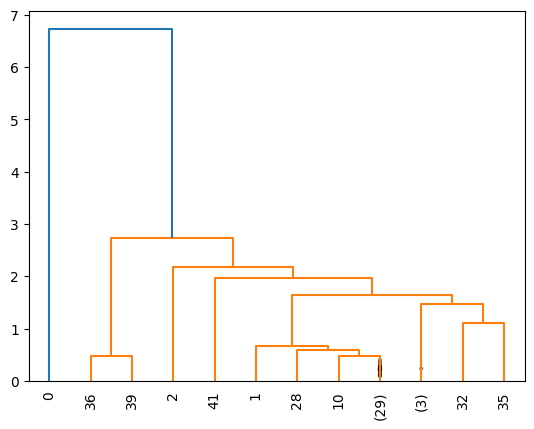

In [54]:
# df_count_stop is a df with columns [' LATITUDE ', ' LONGITUDE ', '1', '2', '3', '4', '5', '6', '7', 'STUD', 'RET', 'WKRS'] 
data = df_stop_count.values

# Custom distance function parameters
coord_weight = 0.3
similarity_weight = 0.7

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Calculate linkage matrix using custom distance function
# The custom distance function is a weighted average of the haversine distance between coordinates and the similarity between the stop counts
linkage_matrix = linkage(data, method='single', metric=lambda x, y: custom_distance(x, y, coord_weight, similarity_weight))

# Create a dendrogram for visualization purposes 
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=10., show_contracted=True)

# Determine clusters based on a desired threshold or number of clusters
threshold = 0.4
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance', depth=2, R=None, monocrit=None)

# print(clusters)

In [55]:
# Adding cluster labels to the stop count dataframe
df_stop_count['Cluster'] = clusters
print(df_stop_count.shape)
df_stop_count.head()

(42, 13)


TICKET_CODE,LATITUDE,LONGITUDE,1,2,3,4,5,6,7,RET,STUD,WKRS,Cluster
0,45.223690,12.280678,3.835821,0.671642,0.776119,1.417910,26.865672,6.940299,53.611940,1.104478,4.776119,0.000000,13
1,45.417992,12.368725,4.061914,3.346640,4.960489,2.250916,29.717312,22.114868,22.293279,1.203259,9.716497,0.334827,7
2,45.418373,12.258713,0.000000,0.000000,0.000000,0.000000,20.000000,60.000000,20.000000,0.000000,0.000000,0.000000,12
3,45.425579,12.332047,9.104478,9.820896,13.970149,9.791045,6.447761,1.432836,47.253731,0.358209,1.820896,0.000000,3
4,45.426720,12.337905,12.552239,13.417910,20.253731,10.074627,6.179104,1.268657,33.208955,0.373134,2.671642,0.000000,3


<Axes: xlabel='Cluster', ylabel='count'>

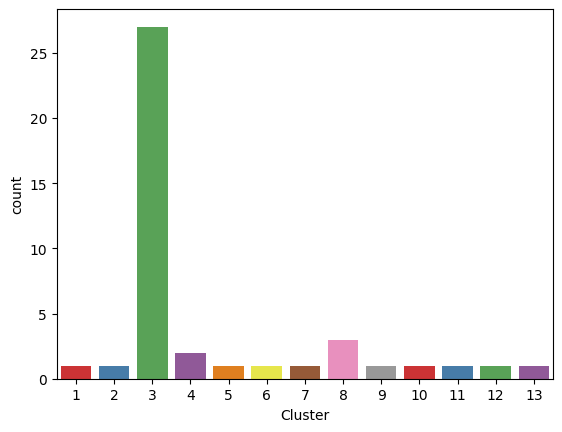

In [56]:
# Countplot of cluster distribution 
sns.countplot(x='Cluster', data=df_stop_count, palette='Set1')

In [57]:
# Create a folium map centered around the mean latitude and longitude
center_lat = np.mean(df_stop_count['LATITUDE'])
center_lon = np.mean(df_stop_count['LONGITUDE'])
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

cluster_colors = {
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'darkred',
    7: 'lightred',
    8: 'beige',
    9: 'darkblue',
    10: 'darkgreen',
    11: 'cadetblue',
    12: 'darkpurple',
    13: 'lightblue',
    14: 'pink',
    15: 'lightgreen',
    16: 'black',
    17: 'lightgray',
    18: 'darkgray',
    19: 'yellow',
    20: 'lightorange'
}

# Create markers for each stop and color them based on clusters
for idx, row in df_stop_count.iterrows():
    cluster_color = cluster_colors.get(row['Cluster'], 'gray')  # Default to gray if cluster color is not defined
    folium.CircleMarker(location=[row['LATITUDE'], row['LONGITUDE']], radius=5, color=cluster_color).add_to(m)
    # Add a label to the marker with the name of the stop obtained by geo-coding the latitude and longitude
    # Obtain the name of the stop by geo-coding the latitude and longitude
    from geopy.geocoders import Nominatim
    geopy = Nominatim(user_agent="my-app5")

    try:
        location = geopy.reverse(f"{row['LATITUDE']}, {row['LONGITUDE']}").address
    except:
        location = "None"
    # Color the marker based on the cluster
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=location, icon=folium.Icon(color=cluster_color)).add_to(m)
m

In [58]:
# Export the map to an HTML file
# Import the necessary libraries
from datetime import datetime
time = datetime.now().strftime("%Y%m%d-%H%M%S")
try:
    m.save('map/' + file_name + '_clustered_' + time + '.html')
    print('Map saved in map/' + file_name + '/' + file_name + '_clustered_' + time + '.html')
except:
    # Create a new folder in map folder
    os.mkdir('map/' + file_name)
    m.save('map/' + file_name + '/' + file_name + '_clustered_' + time + '.html')
    print('Map saved in map/' + file_name + '/' + file_name + '_clustered_' + time + '.html')

Map saved in map/tempesportazioneCompleta/tempesportazioneCompleta_clustered_20230819-092631.html


### Apply hierarchical clustering to the data of the main island of Venice (the most populated cluster)

In [59]:
# Select only the data of the main island of Venice (the cluster most populated)
cluster_main_island = df_stop_count['Cluster'].value_counts().index[0]

print('The cluster with the highest number of stops is the cluster number', cluster_main_island)

cluster_main_island = df_stop_count[df_stop_count['Cluster'] == cluster_main_island]


The cluster with the highest number of stops is the cluster number 3


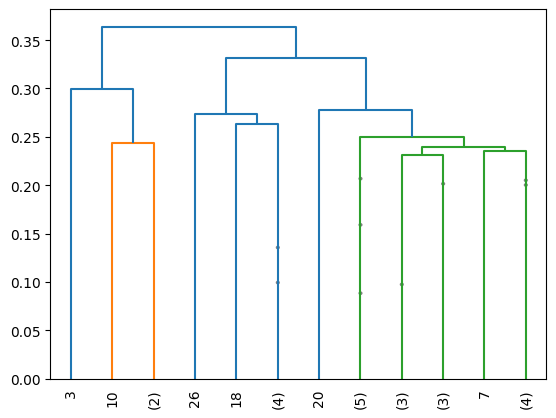

In [60]:
# Apply hierarchical clustering to the data of the main island of Venice (the most populated one)

data = cluster_main_island.values

# Custom distance function parameters
coord_weight = 0.3
similarity_weight = 0.7

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Calculate linkage matrix using custom distance function
# The custom distance function is a weighted average of the haversine distance between coordinates and the similarity between the stop counts
linkage_matrix = linkage(data, method='single', metric=lambda x, y: custom_distance(x, y, coord_weight, similarity_weight))

# Create a dendrogram for visualization purposes 
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=10., show_contracted=True)

# Determine clusters based on a desired threshold or number of clusters
threshold = 0.4
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance', depth=2, R=None, monocrit=None)


In [61]:
# Create a folium map centered around the mean latitude and longitude
center_lat = np.mean(df_stop_count['LATITUDE'])
center_lon = np.mean(df_stop_count['LONGITUDE'])
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

cluster_colors = {
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'darkred',
    7: 'lightred',
    8: 'beige',
    9: 'darkblue',
    10: 'darkgreen',
    11: 'cadetblue',
    12: 'darkpurple',
    13: 'lightblue',
    14: 'pink',
    15: 'lightgreen',
    16: 'black',
    17: 'lightgray',
    18: 'darkgray',
    19: 'yellow',
    20: 'lightorange'
}

# Create markers for each stop and color them based on clusters
for idx, row in cluster_main_island.iterrows():
    cluster_color = cluster_colors.get(row['Cluster'], 'gray')  # Default to gray if cluster color is not defined
    folium.CircleMarker(location=[row['LATITUDE'], row['LONGITUDE']], radius=5, color=cluster_color).add_to(m)
    # Add a label to the marker with the name of the stop obtained by geo-coding the latitude and longitude
    # Obtain the name of the stop by geo-coding the latitude and longitude
    # from geopy.geocoders import Nominatim
    geopy = Nominatim(user_agent="my-app5")
    try:
        location = geopy.reverse(f"{row['LATITUDE']}, {row['LONGITUDE']}").address
    except:
        location = "None"
    # Color the marker based on the cluster
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=location, icon=folium.Icon(color=cluster_color)).add_to(m)
m